In [103]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path):
    """Load and return a JSON object from a file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found -> {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in file {file_path}: {e}")
    return None


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [104]:
# creates a chart with the interpretation selections of Chat GPT, Llama and the Rwp minimization
#includes synthesis, interpretation info, balance score, Rwp, and likelihoods for each LLM

def find_all_choices(json_file, sample):
    sample_choice = {}
    if 1 == 1:
        llama_probs = []
        chat_probs = []
        rwp_vals = []
        sample_choice[sample] = {}
        for interpret, info in json_file[sample].items():
            if interpret == "Synth_Conditions":
                continue
            try:
                llama_score = info["unnormalized_posterior_llama"]
                chat_score = info["unnormalized_posterior"]
                rwp = info["rwp"]
                if all(isinstance(x, (int, float)) for x in [llama_score, chat_score, rwp]):
                    llama_probs.append((interpret, llama_score))
                    chat_probs.append((interpret, chat_score))
                    rwp_vals.append((interpret, rwp))
            except KeyError as e:
                print(f"Missing key in sample '{sample}', interpretation '{interpret}': {e}")
        
        sample_choice[sample]["llama_choice"] = max(llama_probs, key=lambda x: x[1])[0] if llama_probs else None
        sample_choice[sample]["chat_choice"] = max(chat_probs, key=lambda x: x[1])[0] if chat_probs else None
        sample_choice[sample]["rwp_choice"] = min(rwp_vals, key=lambda x: x[1])[0] if rwp_vals else None
    
    return sample_choice
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file = load_json(file_path)
find_all_choices(json_file, "ARR_39")

{'ARR_39': {'llama_choice': 'I_2', 'chat_choice': 'I_1', 'rwp_choice': 'I_1'}}

In [105]:
import pandas as pd
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v2_llama1.json"
json_file = load_json(file_path)
#sample_id = 'ARR_39'  # sample name

def format_predicted_phases(json_file, sample_id, chat_choice): 
    # Format the predicted phases with the weight fraction to be used in a table
    phases = json_file[sample_id][chat_choice]["phases"]
    wfs = json_file[sample_id][chat_choice]["weight_fraction"]
    wfs = [round(wf, 3) for wf in wfs]
    phase_list = ""
    for i in range(len(phases)):
        if not phase_list:
            phase_list += f"({phases[i]} {wfs[i]}%)"
        else: phase_list += f", ({phases[i]} {wfs[i]}%)"
    return phase_list

# Helper function to extract values safely
def assemble_df(sample_id, sample_choice, json_file):
    rows = []
    # assign a row to name the sample being run 
    name_row = {}
    name_row["Selection Method"] = sample_id
    name_row["Choice"] = ""
    name_row["Predicted Phases"] = ""
    name_row["Balance Score"] = ""
    name_row["Rwp"] = ""
    name_row["Chat GPT Likelihood"] = ""
    name_row["Llama Likelihood"] = ""

    # assign Chat GPT row values
    chat_row = {}
    chat_choice = sample_choice[sample_id]["chat_choice"]
    chat_row["Selection Method"] = "Chat GPT"
    chat_row["Choice"] = chat_choice
    chat_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, chat_choice)
    chat_row["Balance Score"] = json_file[sample_id][chat_choice]["balance_score"]
    chat_row["Rwp"] = json_file[sample_id][chat_choice]["rwp"]
    chat_row["Chat GPT Likelihood"] = json_file[sample_id][chat_choice]["LLM_interpretation_likelihood"]
    chat_row["Llama Likelihood"] = json_file[sample_id][chat_choice]["LLM_interpretation_likelihood_llama"]

    #assign Llama row values
    llama_row = {}
    llama_choice = sample_choice[sample_id]["llama_choice"]
    llama_row["Selection Method"] = "Llama"
    llama_row["Choice"] = llama_choice
    llama_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, llama_choice)
    llama_row["Balance Score"] = json_file[sample_id][llama_choice]["balance_score"]
    llama_row["Rwp"] = json_file[sample_id][llama_choice]["rwp"]
    llama_row["Chat GPT Likelihood"] = json_file[sample_id][llama_choice]["LLM_interpretation_likelihood"]
    llama_row["Llama Likelihood"] = json_file[sample_id][llama_choice]["LLM_interpretation_likelihood_llama"]

    #assign lowest Rwp values
    rwp_row = {}
    rwp_choice = sample_choice[sample_id]["rwp_choice"]
    rwp_row["Selection Method"] = "Lowest Rwp"
    rwp_row["Choice"] = rwp_choice
    rwp_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, rwp_choice)
    rwp_row["Balance Score"] = json_file[sample_id][rwp_choice]["balance_score"]
    rwp_row["Rwp"] = json_file[sample_id][rwp_choice]["rwp"]
    rwp_row["Chat GPT Likelihood"] = json_file[sample_id][rwp_choice]["LLM_interpretation_likelihood"]
    rwp_row["Llama Likelihood"] = json_file[sample_id][rwp_choice]["LLM_interpretation_likelihood_llama"]
    rows = [name_row, chat_row, llama_row, rwp_row]
    return rows
rows = []
for sample_id in json_file.keys(): # go through every sample and display a chart with relevant information 
    sample_choice = find_all_choices(json_file, sample_id)
    rows.extend(assemble_df(sample_id, sample_choice, json_file))
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(rows)
df = df[["Selection Method", "Choice", "Predicted Phases", "Balance Score", "Rwp", "Chat GPT Likelihood", "Llama Likelihood"]]
display(df)


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,PG_1048_1,,,,,,
1,Chat GPT,I_3,"(V2O5_59 51.188%), (V3Cr7O15_167 48.812%), (Cr2O3_167 0.0%)",0.9744,4.74,0.7,0.8
2,Llama,I_3,"(V2O5_59 51.188%), (V3Cr7O15_167 48.812%), (Cr2O3_167 0.0%)",0.9744,4.74,0.7,0.8
3,Lowest Rwp,I_1,"(V20CrO52_59 4.341%), (V3Cr7O15_167 46.84%), (Cr2O3_167 0.0%), (V2O5_59 48.82%)",0.9711,4.6,0.55,0.7
4,ARR_39,,,,,,
5,Chat GPT,I_1,(Ga33O50_12 100.0%),0.375,20.11,0.35,0.0
6,Llama,I_2,(Ga2O3_12 100.0%),0.375,20.14,0.35,0.6
7,Lowest Rwp,I_1,(Ga33O50_12 100.0%),0.375,20.11,0.35,0.0
8,TRI_62,,,,,,
9,Chat GPT,I_7,"(Li14V43O114_11 78.118%), (LiVO3_15 21.882%)",0.998889,4.36,0.75,0.8


In [106]:
import textwrap
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file = load_json(file_path)
def print_synthconditions(sample_id,json_file):
    synth_conditions = json_file[sample_id]["Synth_Conditions"]
    target = synth_conditions["Target"]
    precursor1 = synth_conditions["Precursor 1"]
    precursor2 = synth_conditions["Precursor 2"]
    if "Precursor 3" in synth_conditions:
        precursor3 = synth_conditions["Precursor 3"]
    furnace = synth_conditions["Furnace"]
    tempc = synth_conditions["Temperature (C)"]
    tempk = synth_conditions["Temperature (K)"]
    dwell = synth_conditions["Dwell Duration (h)"]
    if "Precursor 3" in synth_conditions:
        print_conditions =textwrap.dedent(f"""
        Target: {target}
        Precursors: {precursor1}, {precursor2}, {precursor3}
        Furnace: {furnace}
        Temperature (C): {tempc}
        Temperature (K): {tempk}
        Dwell Duration (h): {dwell}
        """)
    else:
        print_conditions = textwrap.dedent(f"""
        Synthesis Conditions:                                   
        Target: {target}
        Precursors: {precursor1}, {precursor2}
        Furnace: {furnace}
        Temperature (C): {tempc}
        Temperature (K): {tempk}
        Dwell Duration (h): {dwell}
        """)
    return print_conditions
sample_id = "ARR_39"
print_conditions = print_synthconditions(sample_id,json_file)
print(print_conditions)


Synthesis Conditions:                                   
Target: GaSbO4
Precursors: Ga2O3, Sb2O5
Furnace: BF
Temperature (C): 600.0
Temperature (K): 873.15
Dwell Duration (h): 4.0



In [107]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def find_choices(sample, json_file, model):
    #creates an ordered list of most favorable interpretations for both the LLM model and Rwp values
    rwp_vals = []
    model_scores = []
    for interpret, info in json_file[sample].items():
        if interpret == "Synth_Conditions":
            continue
        rwp = info["rwp"]
        if model == "Llama":
            model_score = info["unnormalized_posterior_llama"]
        if model == "Chat GPT":
            model_score = info["unnormalized_posterior"]
        rwp_vals.append((interpret, rwp))
        model_scores.append((interpret, model_score))
    sample_choice_rwp = sorted(rwp_vals, key=lambda x: x[1])
    sample_choice_rwp = [i[0] for i in sample_choice_rwp]
    sample_choice_model = sorted(model_scores, key=lambda x: x[1],reverse=True)
    sample_choice_model = [i[0] for i in sample_choice_model]
    return [sample_choice_rwp, sample_choice_model]
def get_blues_colors(reference_list, skip_low=0.35):
    """
    Generate `n_phases` shades of blue from the 'Blues' colormap,
    skipping the low-saturation (lighter) colors at the bottom.
    
    Parameters:
        n_phases (int): Number of distinct blues to return.
        skip_low (float): Fraction of the colormap to skip from the bottom (0 to 1).
    
    Returns:
        list of hex colors
    """
    cmap = plt.get_cmap('Blues')
    n_phases = len(reference_list)
    # Sample evenly from the high-saturation portion only
    values = [skip_low + (1 - skip_low) * (i / (n_phases - 1)) for i in range(n_phases)]
    return [mcolors.to_hex(cmap(v)) for v in values]

def generate_colors(reference_list, cmap_name='Blues'):
    cmap = plt.get_cmap(cmap_name, len(reference_list))  # Discretize the colormap
    return [mcolors.to_hex(cmap(i)) for i in range(len(reference_list))]

def graph_interpretation_likelihoods(json_file, sample_id, model):
    # Interpretation names and probabilities
    interpretations = find_choices(sample_id, json_file, model)[1] #
    interpretations.reverse()
    #print(interpretations)
    probabilities = []
    phase_fractions = []
    phase_labels = []
    label_colors = []
    for interpret in interpretations:
        if model == "Llama": #collect llama probabilities 
            probabilities.append(round(json_file[sample_id][interpret]["posterior_probability_llama"],3)*100) 
        if model == "Chat GPT": #collect chat gpt probabilities
            probabilities.append(round(json_file[sample_id][interpret]["posterior_probability"],3)*100)
        wfs = json_file[sample_id][interpret]["weight_fraction"]
        wfs = [((round(i,2))*probabilities[-1]/100) for i in wfs]
        phase_fractions.append(wfs)
        phase_labels.append(json_file[sample_id][interpret]["phases"])

    # assign label colors based on if the LLM or Rwp minimization favors the Interpretation
    choices = find_choices(sample_id,json_file,model)
    for i in range(len(interpretations)): 
        if interpretations[i] == choices[1][0] and interpret == choices[0][0]:
            interpretations[i] = r"$^{\mathbf{*}}$ " + interpretations[i]
        elif interpretations[i] == choices[0][0]: 
            # Rwp minimum interpretation
            interpretations[i] = r"$^{\mathbf{*}}$ "+ interpretations[i]
        #elif interpretations[i] == choices[1][0]:

    # assign colors for each phase (colors are set for all interpretations)
    phases_total = []
    unordered_interprets = json_file[sample_id]
    for interpret, info in unordered_interprets.items():
        if interpret != "Synth_Conditions":
            for phase in info["phases"]:
                    if phase not in phases_total:
                        phases_total.append(phase)
    # create a dictionary with color bindings for each phase predicted in the sample
    phase_colors = dict(zip(phases_total, get_blues_colors(phases_total)))
    #print(phase_colors)
    # create a new list (of lists) with the color for each phase
    color_list = []
    for phases in phase_labels:
        color_interpret = []
        for phase in phases:
            color_interpret.append(phase_colors[phase])
        color_list.append(color_interpret)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 5))  # Wider for more space

    # Plot each interpretation as stacked horizontal bar
    for i in range(len(interpretations)):
        left = 0
        for j in range(len(phase_fractions[i])):
            width = phase_fractions[i][j]
            if width > 0:
                ax.barh(i, width, left=left, color=color_list[i][j], height=0.6)
                left += width

    # Add interpretation names inside the bar (or just left of the bar)
    for i, (name, prob) in enumerate(zip(interpretations, probabilities)):
        ax.text(-1, i, name, va='center', ha='right', fontweight='bold', fontsize=11, color="black")
        ax.text(prob + 1.5, i, f"{round(prob,3)}%", va='center', ha='left', fontsize=10)

    # Customize legend
    legend_handles = [Patch(color=phase_colors[phase], label=phase) for phase in phases_total]
    phase_legend = ax.legend(handles=legend_handles, loc='lower right', frameon=True, fontsize=9)
    ax.add_artist(phase_legend)

    # Axis and layout
    ax.set_xlim(0, max(probabilities) + 10)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel(f'Interpretation Probability (%) Using {model}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    #add seperate legend to identify which framework selected which interpretation
    custom_legend_handles = [
        Line2D([], [], color='black', linestyle='None', label='* "dara" selection', markersize=10)
        ]

    ax.legend(
    handles=custom_legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # X=50% center, Y=just below the plot
    ncol=2,
    frameon=False,
    fontsize=10
    )
    plt.tight_layout()
    plt.show()



In [108]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def find_choices(sample, json_file, model):
    #creates an ordered list of most favorable interpretations for both the LLM model and Rwp values
    rwp_vals = []
    model_scores = []
    for interpret, info in json_file[sample].items():
        if interpret == "Synth_Conditions":
            continue
        rwp = info["rwp"]
        if model == "Llama":
            model_score = info["unnormalized_posterior_llama"]
        if model == "Chat GPT":
            model_score = info["unnormalized_posterior"]
        rwp_vals.append((interpret, rwp))
        model_scores.append((interpret, model_score))
    sample_choice_rwp = sorted(rwp_vals, key=lambda x: x[1])
    sample_choice_rwp = [i[0] for i in sample_choice_rwp]
    sample_choice_model = sorted(model_scores, key=lambda x: x[1],reverse=True)
    sample_choice_model = [i[0] for i in sample_choice_model]
    return [sample_choice_rwp, sample_choice_model]
def get_blues_colors(reference_list, skip_low=0.35):
    """
    Generate `n_phases` shades of blue from the 'Blues' colormap,
    skipping the low-saturation (lighter) colors at the bottom.
    
    Parameters:
        n_phases (int): Number of distinct blues to return.
        skip_low (float): Fraction of the colormap to skip from the bottom (0 to 1).
    
    Returns:
        list of hex colors
    """
    cmap = plt.get_cmap('Blues')
    n_phases = len(reference_list)
    # Sample evenly from the high-saturation portion only
    values = [skip_low + (1 - skip_low) * (i / (n_phases - 1)) for i in range(n_phases)]
    return [mcolors.to_hex(cmap(v)) for v in values]

def generate_colors(reference_list, cmap_name='Blues'):
    cmap = plt.get_cmap(cmap_name, len(reference_list))  # Discretize the colormap
    return [mcolors.to_hex(cmap(i)) for i in range(len(reference_list))]

def graph_interpretation_likelihoods(json_file, sample_id, model):
    # Interpretation names and probabilities
    interpretations = find_choices(sample_id, json_file, model)[1] #
    interpretations.reverse()
    #print(interpretations)
    probabilities = []
    phase_fractions = []
    phase_labels = []
    label_colors = []
    for interpret in interpretations:
        if model == "Llama": #collect llama probabilities 
            probabilities.append(round(json_file[sample_id][interpret]["posterior_probability_llama"],3)*100) 
        if model == "Chat GPT": #collect chat gpt probabilities
            probabilities.append(round(json_file[sample_id][interpret]["posterior_probability"],3)*100)
        wfs = json_file[sample_id][interpret]["weight_fraction"]
        wfs = [((round(i,2))*probabilities[-1]/100) for i in wfs]
        phase_fractions.append(wfs)
        phase_labels.append(json_file[sample_id][interpret]["phases"])

    # assign label colors based on if the LLM or Rwp minimization favors the Interpretation
    choices = find_choices(sample_id,json_file,model)
    for i in range(len(interpretations)): 
        if interpretations[i] == choices[1][0] and interpret == choices[0][0]:
            interpretations[i] = r"$^{\mathbf{*}}$ " + interpretations[i]
        elif interpretations[i] == choices[0][0]: 
            # Rwp minimum interpretation
            interpretations[i] = r"$^{\mathbf{*}}$ "+ interpretations[i]
        #elif interpretations[i] == choices[1][0]:

    # assign colors for each phase (colors are set for all interpretations)
    phases_total = []
    unordered_interprets = json_file[sample_id]
    for interpret, info in unordered_interprets.items():
        if interpret != "Synth_Conditions":
            for phase in info["phases"]:
                    if phase not in phases_total:
                        phases_total.append(phase)
    # create a dictionary with color bindings for each phase predicted in the sample
    phase_colors = dict(zip(phases_total, get_blues_colors(phases_total)))
    #print(phase_colors)
    # create a new list (of lists) with the color for each phase
    color_list = []
    for phases in phase_labels:
        color_interpret = []
        for phase in phases:
            color_interpret.append(phase_colors[phase])
        color_list.append(color_interpret)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 5))  # Wider for more space

    # Plot each interpretation as stacked horizontal bar
    for i in range(len(interpretations)):
        left = 0
        for j in range(len(phase_fractions[i])):
            width = phase_fractions[i][j]
            if width > 0:
                ax.barh(i, width, left=left, color=color_list[i][j], height=0.6)
                left += width

    # Add interpretation names inside the bar (or just left of the bar)
    for i, (name, prob) in enumerate(zip(interpretations, probabilities)):
        ax.text(-1, i, name, va='center', ha='right', fontweight='bold', fontsize=11, color="black")
        ax.text(prob + 1.5, i, f"{round(prob,3)}%", va='center', ha='left', fontsize=10)

    # Customize legend
    legend_handles = [Patch(color=phase_colors[phase], label=phase) for phase in phases_total]
    phase_legend = ax.legend(handles=legend_handles, loc='lower right', frameon=True, fontsize=9)
    ax.add_artist(phase_legend)

    # Axis and layout
    ax.set_xlim(0, max(probabilities) + 10)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel(f'Interpretation Probability (%) Using {model}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    #add seperate legend to identify which framework selected which interpretation
    custom_legend_handles = [
        Line2D([], [], color='black', linestyle='None', label='* "dara" selection', markersize=10)
        ]

    ax.legend(
    handles=custom_legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # X=50% center, Y=just below the plot
    ncol=2,
    frameon=False,
    fontsize=10
    )
    plt.tight_layout()
    plt.show()



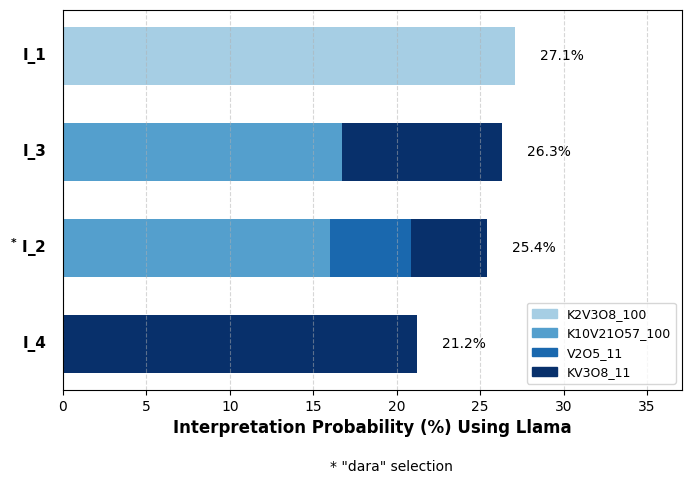

In [109]:
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama3.json"
json_file = load_json(file_path)
sample_id = "TRI_84"
model = "Llama"
graph_interpretation_likelihoods(json_file, sample_id, model)

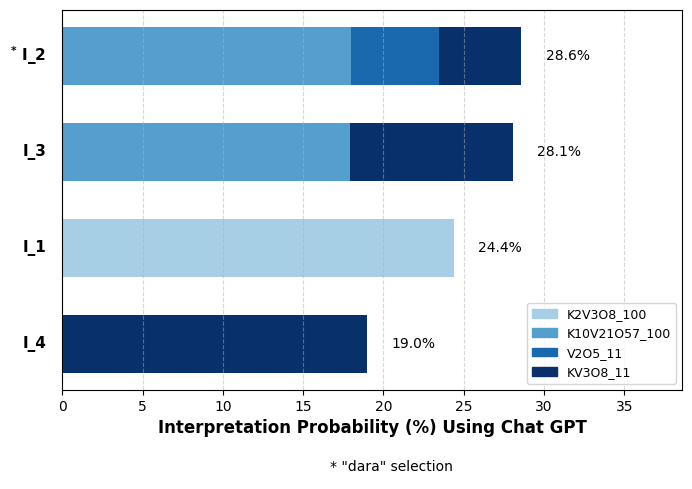

In [110]:
sample_id = "TRI_84"
model = "Chat GPT"
graph_interpretation_likelihoods(json_file, sample_id, model)

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def samples_choices(json_file):
    # sample_choice = {}
    # for sample in json_file:
    #     sample_choice[sample] = {}
    #     llama_probs = []
    #     chat_probs = []
    #     for interpretation in json_file[sample]:
    #         if interpretation != "Synth_Conditions":
    #             llama_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior_llama"]))
    #             chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
    #     llama_choice = max(llama_probs, key=lambda x: x[1])[0]
    #     chat_choice = max(chat_probs, key=lambda x: x[1])[0]
    #     sample_choice[sample]["llama_choice"] = llama_choice
    #     sample_choice[sample]["chat_choice"] = chat_choice
    sample_choice = {}
    for sample in json_file:
        sample_choice[sample] = {}
        llama_probs = []
        chat_probs = []
        for interpretation in json_file[sample]:
            if interpretation != "Synth_Conditions":
                if "unnormalized_posterior_llama" in json_file[sample][interpretation]:
                    llama_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior_llama"]))
                    chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
                else:
                    chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
        if llama_probs:
            llama_choice = max(llama_probs, key=lambda x: x[1])[0]
        else:
            llama_choice = "I_1 (oops)"
        chat_choice = max(chat_probs, key=lambda x: x[1])[0]
        sample_choice[sample]["llama_choice"] = llama_choice
        sample_choice[sample]["chat_choice"] = chat_choice

    return sample_choice
def count_agree(sample_choice):
    agree = 0 
    disagree = 0 
    for sample, choices in sample_choice.items():
        if choices["chat_choice"] == choices["llama_choice"]:
            agree += 1
        else: disagree += 1
    return [agree, disagree]


In [112]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

def graph_all(data1, data2, data3, data4):
    
    ### vertical graph ###

    all_data = [data1, data2, data3, data4]
    data5_agree = sum([i[0] for i in all_data]) / len(all_data)
    data5_dis = sum([i[1] for i in all_data]) / len(all_data)
    all_data.append([data5_agree, data5_dis])
    labels = ['Agree', 'Disagree']

    fig = plt.figure(figsize=(6, 6.5))
    gs = GridSpec(
        3, 2, figure=fig,
        height_ratios=[1, 1, 1.1],
        wspace=0.15,
        hspace=0.25
    )

    axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, :])
    ]

    colors = ['#2874a6', '#b03a2e']

    for i, ax in enumerate(axes):
        data = all_data[i]

        width = 0.45 if i == 4 else 0.5

        wedges, _ = ax.pie(
            data,
            wedgeprops=dict(width=width),
            startangle=90,
            colors=colors
        )

        kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
        for j, p in enumerate(wedges):
            percent = round(data[j] / sum(data) * 100)
            ang = (p.theta2 - p.theta1) / 2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(
                f"{percent}%",
                xy=(x, y),
                xytext=(1.3 * np.sign(x), 1.4 * y),
                horizontalalignment=horizontalalignment,
                fontsize=9,
                **kw
            )

        if i < 4:
            ax.set_title(f"Run {i+1}", fontsize=11, fontweight='bold')
        else:
            ax.set_title("Average", fontsize=13, fontweight='bold')

    legend_patches = [Patch(color=colors[i], label=labels[i]) for i in range(2)]
    fig.legend(
        handles=legend_patches,
        loc='lower right',
        ncol=2,
        fontsize=10,
        frameon=True,
        fancybox=True,
    )

    fig.suptitle("AIF Agreement Using Chat GPT Vs. Llama\n(15 Samples)", fontsize=15, fontweight='bold')

    # Adjust tight_layout rect and subplots_adjust for better spacing
    plt.tight_layout(rect=[0, 0.1, 1, 0.88])  # Less bottom padding, more top padding
    fig.subplots_adjust(top=0.9, bottom=0.1)

    plt.show()


/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_2278/3565646271.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.88])  # Less bottom padding, more top padding


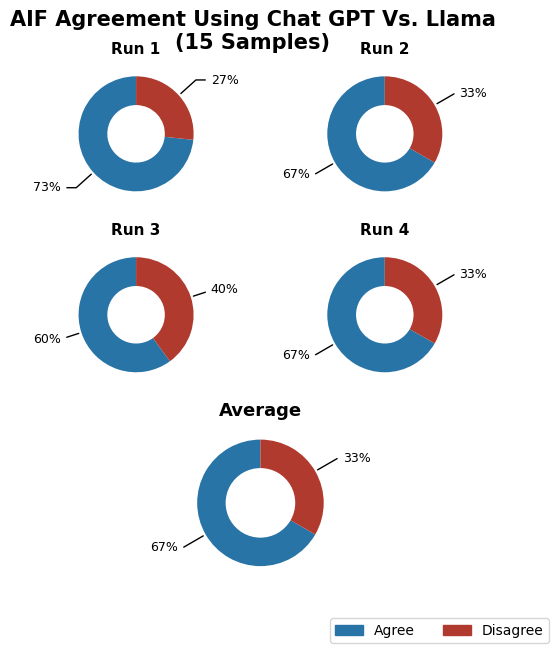

In [113]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama183.json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama184.json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama185.json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama186.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)

choices1 = samples_choices(json_file1)
choices2 = samples_choices(json_file2)
choices3 = samples_choices(json_file3)
choices4 = samples_choices(json_file4)

count1 = count_agree(choices1)
count2 = count_agree(choices2)
count3 = count_agree(choices3)
count4 = count_agree(choices4)

graph_all(count1,count2,count3,count4)

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
def count_errors_noPrint(json_file):
    missing_interpret = 0
    missing_phase = 0
    correct_interpret = 0
    for sample in json_file:
        flag = False
        for interpret in json_file[sample]:
            if interpret not in ["Synth_Conditions"]:
                if "LLM_interpretation_likelihood_llama" not in json_file[sample][interpret]:
                   
                    if flag == False:
                        missing_interpret += 1
                    flag = True
                    continue
                gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                phases_llama = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                phases_chat = list(json_file[sample][interpret]["LLM_phases_likelihood"].keys())
                weightfractions = json_file[sample][interpret]["weight_fraction"]
                if len(phases_llama) != len(weightfractions):
            
                    if flag == False:
                        missing_phase +=1
                    flag = True
                    continue
                if len(phases_chat) != len(weightfractions):
                    
                    if flag == False:
                        missing_phase += 1
                    flag = True
                    continue 
        if flag == False:
            correct_interpret += 1
    return [missing_phase, missing_interpret, correct_interpret]

def graph_all(data1, data2, data3, data4):
    ### horizontal graph ###    

    
    all_data = [data1, data2, data3, data4]
    data5_agree = sum([i[0] for i in all_data]) / len(all_data)
    data5_dis = sum([i[1] for i in all_data]) / len(all_data)
    all_data.append([data5_agree, data5_dis])
    labels = ['Agree', 'Disagree']

    fig = plt.figure(figsize=(9, 6))
    gs = GridSpec(
        2, 3, figure=fig,
        width_ratios=[1, 1, 1],
        height_ratios=[1, 1],
        wspace=0.3,
        hspace=0.3
    )

    axes = [
        fig.add_subplot(gs[0, 0]),      # Run 1 (top-left)
        fig.add_subplot(gs[0, 1]),      # Run 2 (top-middle)
        fig.add_subplot(gs[1, 0]),      # Run 3 (bottom-left)
        fig.add_subplot(gs[1, 1]),      # Run 4 (bottom-middle)
        fig.add_subplot(gs[:, 2])       # Average (right column, spanning both rows)
    ]

    colors = ['#2874a6', '#b03a2e']
    list_percent = []
    for i, ax in enumerate(axes):
        data = all_data[i]
        width = 0.45 if i == 4 else 0.5

        wedges, _ = ax.pie(
            data,
            wedgeprops=dict(width=width),
            startangle=90,
            colors=colors
        )

        # Annotate percentages just outside the donut
        for j, p in enumerate(wedges):
            percent = round(data[j] / sum(data) * 100)
            ang = (p.theta2 + p.theta1) / 2.
            r = 1.1
            x = r * np.cos(np.deg2rad(ang))
            y = r * np.sin(np.deg2rad(ang))
            horizontalalignment = "left" if x > 0 else "right"
            if j == 0:
                list_percent.append(percent)
            ax.annotate(
                f"{percent}%",
                xy=(x, y),
                ha=horizontalalignment,
                va='center',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
            )

        if i < 4:
            ax.set_title(f"Run {i+1}", fontsize=11, fontweight='bold')
        else:
            st_dev = np.std(list_percent)
            ax.set_title(f"Average" + "\n" + rf"($\sigma = {st_dev:.3f}\%$)", fontsize=13, fontweight='bold')

    legend_patches = [Patch(color=colors[i], label=labels[i]) for i in range(2)]
    fig.legend(
        handles=legend_patches,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.02),
        ncol=2,
        fontsize=10,
        frameon=True,
        fancybox=True,
    )

    fig.suptitle("AIF Agreement Using Chat GPT Vs. Llama\n(15 Samples)", fontsize=15, fontweight='bold')

    plt.tight_layout(rect=[0, 0.08, 1, 0.9])
    fig.subplots_adjust(top=0.87, bottom=0.12)

    plt.show()


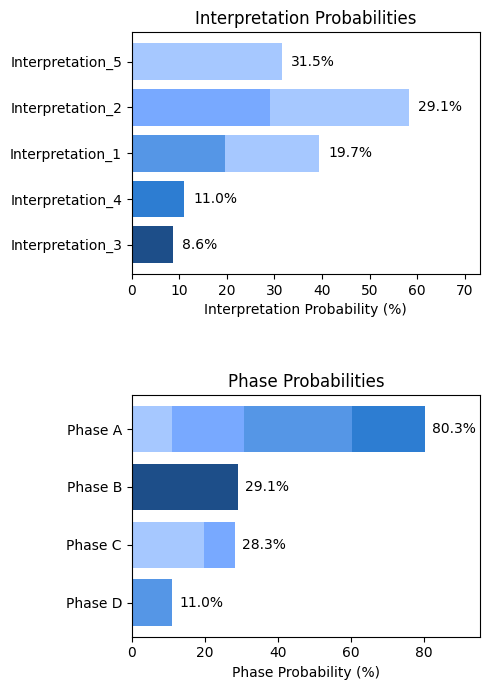

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Data
interpretations = ['Interpretation_5', 'Interpretation_2', 'Interpretation_1', 'Interpretation_4', 'Interpretation_3']
interp_probs = [31.5, 29.1, 19.7, 11.0, 8.6]

interp_phase_colors = [
    ['#a6c8ff'],
    ['#78a9ff', '#a6c8ff'],
    ['#5596e6', '#a6c8ff'],
    ['#2d7dd2'],
    ['#1d4e89']
]

phases = ['Phase A', 'Phase B', 'Phase C', 'Phase D']
phase_probs = [80.3, 29.1, 28.3, 11.0]

bars = [
    [11.0, 19.7, 29.6, 20.0],
    [29.1],
    [19.7, 8.6],
    [11.0]
]

blue_shades = ['#a6c8ff', '#78a9ff', '#5596e6', '#2d7dd2', '#1d4e89']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7))  # Increased height for more space

# Top plot: Interpretation Probabilities (stacked bar)
lefts = np.zeros(len(interpretations))
for i, colors in enumerate(interp_phase_colors):
    width = interp_probs[i]
    for color in colors:
        ax1.barh(interpretations[i], width, left=lefts[i], color=color)
        lefts[i] += width
    ax1.text(lefts[i] + 2, i, f"{interp_probs[i]:.1f}%", va='center', ha='left', color='black', fontsize=10)

max_right = max(lefts) + 15
ax1.set_xlim(0, max_right)
ax1.set_xlabel("Interpretation Probability (%)")
ax1.set_title("Interpretation Probabilities")
ax1.invert_yaxis()

# Bottom plot: Phase Probabilities (stacked bar)
phase_positions = np.arange(len(phases))
left = np.zeros(len(phases))
color_idx = 0

for i, bar in enumerate(bars):
    for val in bar:
        ax2.barh(phases[i], val, left=left[i], color=blue_shades[color_idx % len(blue_shades)])
        left[i] += val
        color_idx += 1
    ax2.text(left[i] + 2, i, f"{phase_probs[i]:.1f}%", va='center', ha='left', color='black', fontsize=10)

max_right_phase = max(left) + 15
ax2.set_xlim(0, max_right_phase)
ax2.set_xlabel("Phase Probability (%)")
ax2.set_title("Phase Probabilities")
ax2.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Add more vertical space between the two subplots
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import matplotlib.patheffects
import math
def categorize_samples_suberror(json_file, sample_choices):
    """
    Categorize each sample as:
    - agree_no_error
    - agree_missing_phase
    - agree_missing_interpretation
    - disagree_no_error
    - disagree_missing_phase
    - disagree_missing_interpretation
    """
    result = {}
    for sample in json_file:
        # Determine agree/disagree
        if sample_choices[sample]["llama_choice"] == sample_choices[sample]["chat_choice"]:
            base = "agree"
        else:
            base = "disagree"
        # Check for errors
        error = None
        for interpret in json_file[sample]:
            if interpret == "Synth_Conditions":
                continue
            info = json_file[sample][interpret]
            if "LLM_interpretation_likelihood_llama" not in info:
                error = "missing_interpretation"
                break
            phases_llama = list(info["LLM_phases_likelihood_llama"].keys())
            weightfractions = info["weight_fraction"]
            if len(phases_llama) != len(weightfractions):
                error = "missing_phase"
                break
        if error is None:
            result[sample] = f"{base}_no_error"
        elif error == "missing_phase":
            result[sample] = f"{base}_missing_phase"
        elif error == "missing_interpretation":
            result[sample] = f"{base}_missing_interpretation"
    return result

def count_subcategories(categorized):
    agree_no_error = sum(1 for v in categorized.values() if v == "agree_no_error")
    agree_missing_phase = sum(1 for v in categorized.values() if v == "agree_missing_phase")
    agree_missing_interpretation = sum(1 for v in categorized.values() if v == "agree_missing_interpretation")
    disagree_no_error = sum(1 for v in categorized.values() if v == "disagree_no_error")
    disagree_missing_phase = sum(1 for v in categorized.values() if v == "disagree_missing_phase")
    disagree_missing_interpretation = sum(1 for v in categorized.values() if v == "disagree_missing_interpretation")
    return [
        agree_no_error, agree_missing_phase, agree_missing_interpretation,
        disagree_no_error, disagree_missing_phase, disagree_missing_interpretation
    ]
def graph_all_with_suberrors(json_files, run_labels=None, y_val=1.04):
    n_runs = len(json_files)
    
    colors = [
        "#2874a6",  # agree_no_error (blue)
        "#2874a6",  # agree_missing_phase (blue, hatched)
        "#2874a6",  # agree_missing_interpretation (blue, double hatched)
        "#b03a2e",  # disagree_no_error (red)
        "#b03a2e",  # disagree_missing_phase (red, hatched)
        "#b03a2e",  # disagree_missing_interpretation (red, double hatched)
    ]
    hatches = [
        None,        # agree_no_error
        "//",        # agree_missing_phase
        "xx",        # agree_missing_interpretation
        None,        # disagree_no_error
        "//",        # disagree_missing_phase
        "xx",        # disagree_missing_interpretation
    ]
    labels = [
        "Agree", "Agree (Missing Phase)", "Agree (Missing Interpretation)",
        "Disagree", "Disagree (Missing Phase)", "Disagree (Missing Interpretation)"
    ]

    all_data = []
    for json_file in json_files:
        sample_choices = samples_choices(json_file)
        categorized = categorize_samples_suberror(json_file, sample_choices)
        counts = count_subcategories(categorized)
        all_data.append(counts)
    #label subplots
    flag = []
    if run_labels is None:
        run_labels =[]
        flag = []
        for i in range(n_runs):
            if all_data[i][2] != 0 or all_data[i][5] != 0:
                run_labels.append(f"Run {i+1} (Data Excluded)")
                flag.append(i)
            else:
                run_labels.append(f"Run {i+1}")

    # Add average
    avg = [np.mean([all_data[d][i] for d in range(len(all_data)) if d not in flag]) for i in range(6)]
    data_std = [all_data[d][0]+all_data[d][1] for d in range(len(all_data)) if d not in flag]
    std = round(np.std(data_std),2)
    all_data.append(avg)
    run_labels.append(f"Average\n(" + r'$\sigma$' + f" = {std} Samples)")

    # Dynamic grid: 2 columns for runs, as many rows as needed, average in last column, centered
    n_run_plots = len(json_files)
    n_rows = 2
    n_columns = math.ceil((n_run_plots + 1)/2)
    fig = plt.figure(figsize=(3*(2+1), 3*n_rows))
    gs = fig.add_gridspec(n_rows, n_columns, width_ratios=[1, 1, 1.1], wspace=0.3, hspace=0.3)

    axes = []
    # Place run plots
    for idx in range(n_run_plots):
        row = idx % 2
        col = idx // 2
        axes.append(fig.add_subplot(gs[row, col]))
    # Place average plot in last column, vertically centered
    avg_row = n_rows // 2 if n_rows > 1 else 0
    axes.append(fig.add_subplot(gs[avg_row, 2]))

    for i, (ax, data, run_label) in enumerate(zip(axes, all_data, run_labels)):
        wedges, _ = ax.pie(
            data,
            wedgeprops=dict(width=0.5),
            startangle=90,
            colors=colors,
        )
        # Add hatches for error sections
        for j, wedge in enumerate(wedges):
            if hatches[j]:
                wedge.set_hatch(hatches[j])
        # Annotate (outside, no background, skip zeros)
        for j, p in enumerate(wedges):
            if data[j] == 0:
                continue
            number = data[j]
            ang = (p.theta2 + p.theta1) / 2.
            r = 1.25  # slightly outside the donut
            x = r * np.cos(np.deg2rad(ang))
            y = r * np.sin(np.deg2rad(ang))
            ax.annotate(
                f"{number}",
                xy=(x, y),
                ha="center",
                va="center",
                fontsize=10,
                color="black",
            )
        # Calculate agree/disagree counts for center text
        agree_count = data[0] + data[1] + data[2]
        disagree_count = data[3] + data[4] + data[5]
        total = agree_count + disagree_count
        center_text = f"{int(agree_count)}/{int(total)}"
        ax.text(0, 0, center_text, ha='center', va='center', fontsize=12,fontweight='bold', color='black')
        
        ax.set_title(run_label, fontsize=13, fontweight='bold',pad=13)

    # Custom legend
    legend_patches = [
        Patch(facecolor="#2874a6", label="Agree"),
        Patch(facecolor="#b03a2e", label="Disagree"),
        Patch(facecolor="none",label="Missing Phase", hatch="//", edgecolor="black"),
        Patch(facecolor="none",label="Missing Interpretation (Unable to use Data)", hatch="xx", edgecolor="black"),
    ]
    fig.legend(
        handles=legend_patches,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.0),
        ncol=2,
        fontsize=11,
        frameon=True,
        fancybox=True,
    )
    fig.suptitle("AIF Agreement & LLM Response Error Subcategories\n(15 Samples)", fontsize=15,fontweight='bold',y=y_val)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_2278/2281748160.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


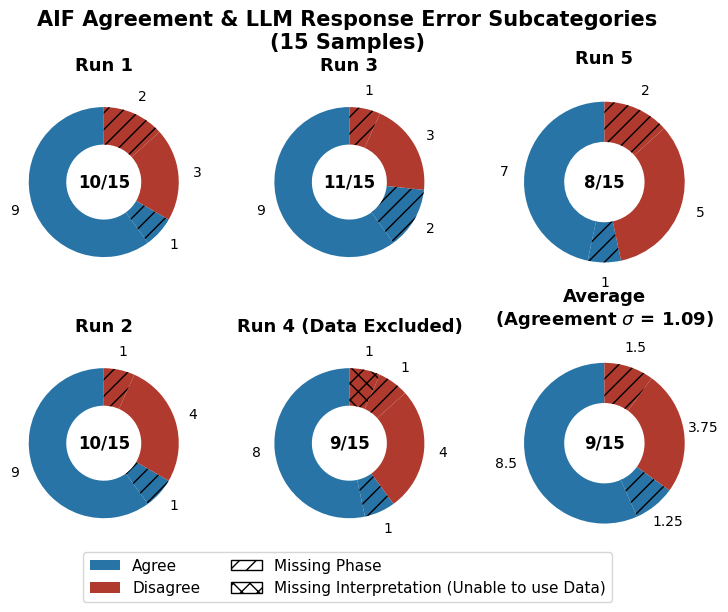

In [241]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama2.json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama3.json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama4.json"
json_file5_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama5.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4,json_file5],y_val=1)

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_2278/2281748160.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


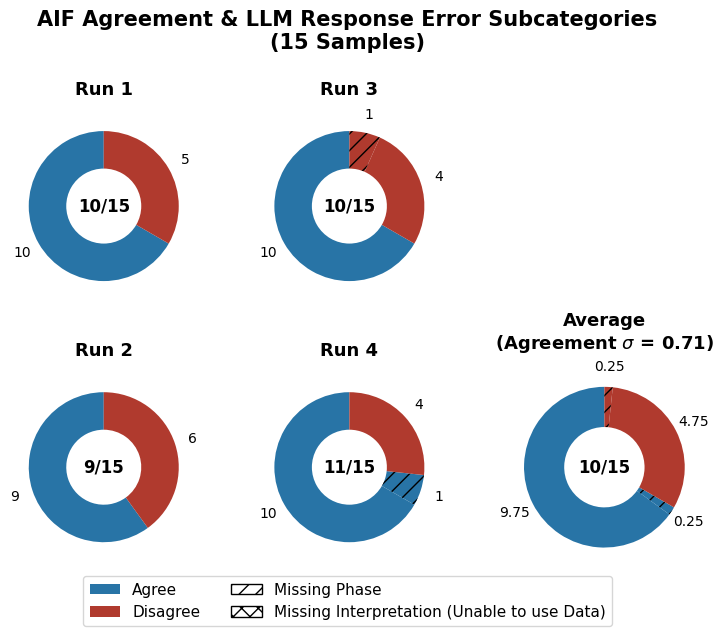

In [242]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v2_llama1.json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v2_llama2.json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v2_llama3.json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v2_llama4.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4])

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_2278/2281748160.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


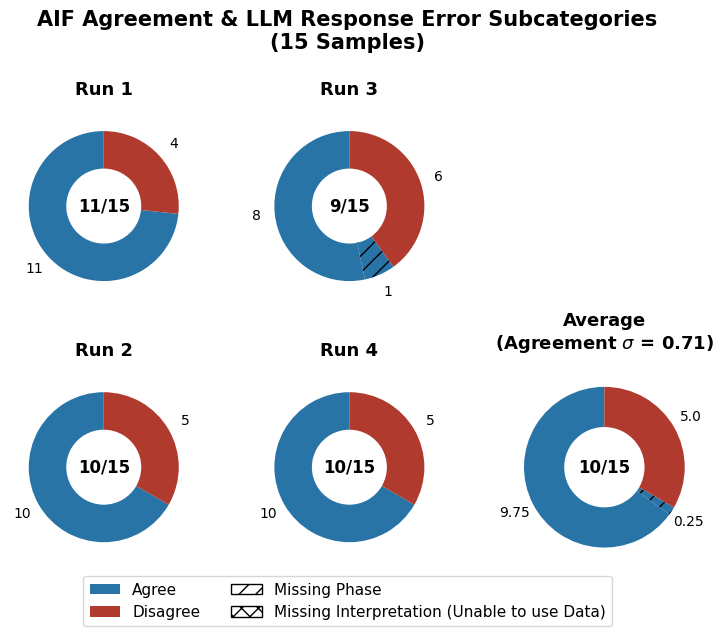

In [243]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama183.json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama184.json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama185.json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/PromptTest/interpretations_llm_v2_llama186.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4])